In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True

### Reading in the spectra

In [3]:
pmsu = pd.read_csv('spectra/GJ1243_PMSU1.txt',delim_whitespace=True, skiprows=1,names=('wave_cal','flux_cal'))
#pmsu

In [4]:
pmsu_flux_cal = pmsu['flux_cal'].values *2

In [5]:
pmsu_wave = pmsu['wave_cal'].values

In [6]:
m4_template = pd.read_csv('spectra/m4_template.dat',delim_whitespace=True, skiprows=13,names=('wave','log_flux'))
#wavelength in microns
m4_template

,wave,log_flux
0,0.115000,-99.000000
1,0.115500,-99.000000
2,0.116000,-99.000000
3,0.116500,-99.000000
4,0.117000,-99.000000
...,...,...
44198,5.071754,3.107181
44199,5.072759,3.155765
44200,5.073764,3.144714
44201,5.074769,3.107299


In [7]:
m4_flux = 10** m4_template['log_flux'].values #removing log units 
m4_wave = m4_template['wave'].values * 10000 #converting units microns to Angstroms

### Calibrating the m4 template to the GJ 1243 spectrum

In [8]:
x1 = np.where((pmsu_wave >= 7200) & (pmsu_wave <= 7450))
x2 = np.where((m4_wave >= 7200) & (m4_wave <= 7450))
#print(x1)
#print(x2)

flux_convert = np.nanmedian(pmsu_flux_cal[x1]) / np.nanmedian(m4_flux[x2])
print(flux_convert)

1.8025093969689897e-18


In [9]:
flux_mask = (np.where(pmsu_wave < 7500))

Text(0, 0.5, 'Flux[erg $s^{-1} cm^{-2}A^{-1}$]')

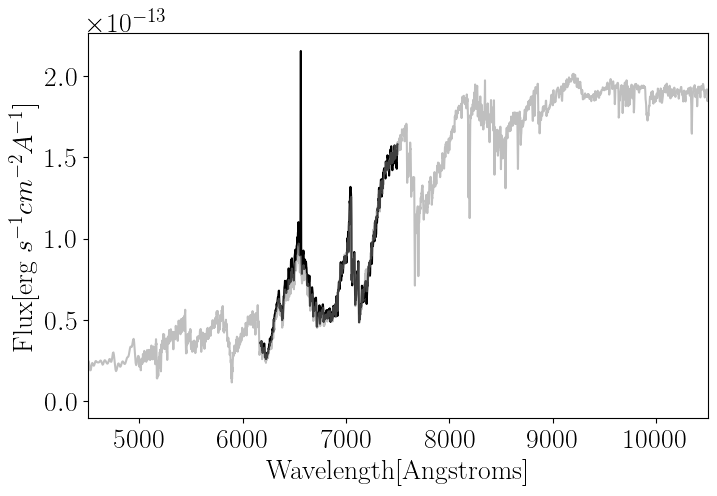

In [10]:
plt.plot(pmsu_wave[flux_mask],pmsu_flux_cal[flux_mask],color='k')
plt.plot(m4_wave,m4_flux*flux_convert,color='grey',alpha=.5)
plt.xlim(4500,10500)
plt.xlabel('Wavelength[Angstroms]')
plt.ylabel('Flux[erg $s^{-1} cm^{-2}A^{-1}$]')

### Reading in the TESS + Kepler filter curves

In [11]:
tess_filter = pd.read_csv('spectra/tess-response-function-v1.0.csv',names=('wave','l_transmission'),skiprows=8,delimiter=',') #wavelength in nm
kepler_filter = pd.read_csv('spectra/kepler_response_hires1.txt',names=('wave','l_transmission'),skiprows=9,delim_whitespace=True,) #wavelength in nm

In [12]:
#(tess_filter['wave'].values) 

In [13]:
# Adjusting units

tessfk_wave = tess_filter['wave'].values * 10
tessfk_tm = tess_filter['l_transmission'].values 
tess_tm_norm = tess_filter['l_transmission'].values/np.max(tess_filter['l_transmission'].values)

kepfk_wave = kepler_filter['wave'].values * 10
kepfk_tm = kepler_filter['l_transmission'].values
kep_tm_norm = kepler_filter['l_transmission'].values/np.max(kepler_filter['l_transmission'].values)

In [14]:
print((kep_tm_norm*np.max(pmsu_flux_cal))[10])
print((tessfk_tm*np.max(pmsu_flux_cal))[10])

1.7277561379310343e-16
8.456617647058771e-15


In [15]:
print(tessfk_wave[1])

4637.702503681885


In [16]:
tessfk_tm*np.max(pmsu_flux_cal)/np.nanmedian(tessfk_tm*np.max(pmsu_flux_cal))-1

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -0.99492901, -0.98884381, -0.97667343,
       -0.96450304, -0.94320487, -0.92494929, -0.90060852, -0.87322515,
       -0.84279919, -0.80933063, -0.76673428, -0.71805274, -0.62373225,
       -0.68154158, -0.57809331, -0.50811359, -0.4168357 , -0.36511156,
       -0.30425963, -0.25557809, -0.18255578, -0.07910751,  0.00608519,
        0.07606491,  0.15212982,  0.22819473,  0.2494929 ,  0.2525355 ,
        0.25557809,  0.26166329,  0.26166329,  0.26470588,  0.26470588,
        0.27079108,  0.27383367,  0.27383367,  0.27991886,  0.27991886,
        0.27991886,  0.28600406,  0.28600406,  0.28904665,  0.29208925,
        0.29513185,  0.30121704,  0.30121704,  0.30121704,  0.30425963,
        0.31034483,  0.31338742,  0.31643002,  0.31643002,  0.31643002,
        0.31947262,  0.31947262,  0.32251521,  0.31947262,  0.31947262,
        0.32555781,  0.32860041,  0.331643  ,  0.33772819,  0.34

Text(0, 0.5, 'Flux')

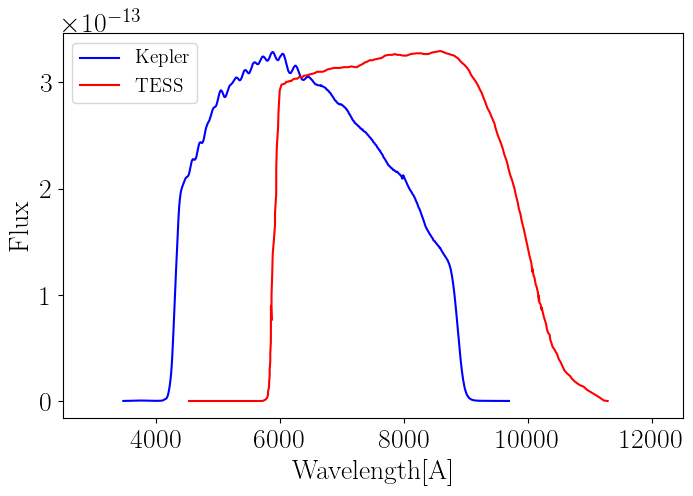

In [17]:
plt.plot(kepfk_wave,kep_tm_norm*np.max(pmsu_flux_cal),color='blue',label='Kepler')
plt.plot(tessfk_wave,tessfk_tm*np.max(pmsu_flux_cal),color='red',label='TESS')
plt.xlim(2500,12500)
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Wavelength[A]')
plt.ylabel('Flux')

### Now we clip the spectrum to match the filter wavelength range

In [18]:
clipk = np.where((m4_wave >= np.min(kepfk_wave)) & (m4_wave <= np.max(kepfk_wave)))

m4_wave_klim = m4_wave[clipk]
m4_flux_klim = m4_flux[clipk] * flux_convert

In [19]:
print((clipk))
print(m4_wave)
print(np.max(kepfk_wave))
print(max(kepfk_wave))

(array([  467,   468,   469, ..., 38176, 38177, 38178]),)
[ 1150.     1155.     1160.    ... 50737.638 50747.69  50757.751]
9700
9700


In [20]:
#print(m4_wave)
#print(m4_flux)
#print(m4_wave[clipk])
#print(flux_convert)
print(m4_flux[clipk])

[  1220.11818493   1301.67540804   1116.06066009 ... 105552.37264882
 108508.36010357 108829.51656916]


In [21]:
clipt = np.where((m4_wave >= np.min(tessfk_wave))&(m4_wave <= np.max(tessfk_wave)))

m4_wave_tlim = m4_wave[clipt]
m4_flux_tlim = m4_flux[clipt] * flux_convert

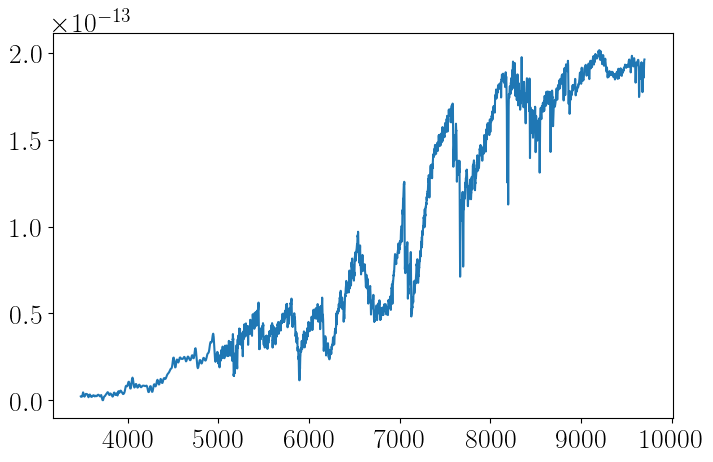

In [22]:
plt.plot(m4_wave_klim,m4_flux_klim)
#plt.plot(m4_wave_tlim,m4_flux_tlim)

### Resampling the filter on to spectrum wavelength grid

In [23]:
print(len(tessfk_wave))
print(len(tessfk_tm))
print(len(m4_wave_tlim))

179
179
38084


In [24]:
from astropy import units as u
tm_tess = np.interp(m4_wave_tlim,tessfk_wave,tessfk_tm)
tm_kep = np.interp(m4_wave_klim,kepfk_wave,kep_tm_norm)

x50t = np.where(tm_tess >= max(tm_tess)/2.)
FWHM_t = max(tm_tess[x50t]) - min(tm_tess[x50t]) # in Angstroms

x50k = np.where(tm_kep >= max(tm_kep)/2.)
FWHM_k = max(tm_kep[x50k]) - min(tm_kep[x50k]) # in Angstroms


plx = 83.4814  # where did Jim get this parallax value?Gaia DR2 slightly different from what's on simbad 83.4940 
plx_err = 0.0366
dist = (1000. / plx) * u.pc

print('Distance (pc) = ',dist )


Distance (pc) =  11.978716217025589 pc


In [25]:
1000. / plx * u.pc

<Quantity 11.97871622 pc>

In [26]:
m4_wave_tlim

array([ 4545.   ,  4550.   ,  4555.   , ..., 11283.979, 11287.24 ,
       11290.489])

In [27]:
np.log10(np.trapz(m4_flux_tlim * tm_tess, x=m4_wave_tlim)* (2. * np.pi * dist.to('cm').value**2))

30.653468540772803

In [28]:
m4_wave_tlim

array([ 4545.   ,  4550.   ,  4555.   , ..., 11283.979, 11287.24 ,
       11290.489])

### Convolve spectrum with filter & Calculate luminosity

In [29]:
tess_lum = np.log10(np.trapz(m4_flux_tlim * tm_tess, x=m4_wave_tlim)* (2. * np.pi * dist.to('cm').value**2))

kep_lum = np.log10(np.trapz(m4_flux_klim * tm_kep, x=m4_wave_klim)* (2. * np.pi * dist.to('cm').value**2))

print('log Luminosity TESS = ',tess_lum)
print('log Luminosity KEPLER = ', kep_lum)


log Luminosity TESS =  30.653468540772803
log Luminosity KEPLER =  30.354766144311125


In [30]:
ang_units = u.erg / (u.cm ** 2 * u.s * u.AA * u.sr)

In [31]:
ang_units

Unit("erg / (Angstrom cm2 s sr)")

In [33]:
from astropy.modeling.models import BlackBody
from astropy import units as u
temperature=10000*u.K
bb = BlackBody(temperature=temperature,scale=1000*ang_units) #if you change units on scale it changes results of bb in each filter curve

#with a bb scale of 10000 we got a 1.6 flux ratio, for a 60% diff
#with a bb scale of 1 we get the same ; a 1.6 flux ratio, for a 60% diff
#without setting a scale we get the wrong units but Flux Ratio: 1.026447822408214;log Flux Ratio: 0.011336877704532924 
#which is closer to the 2% change we see with isochrone analysis

#bb2 = BlackBody(temperature=temperature,scale=1000*ang_units)



In [34]:
wavelengths = np.logspace(np.log10(1000), np.log10(3e4), num=1000) * u.AA
bb_result1 = bb(wavelengths)
#bb_result2 = bb2(wavelengths)

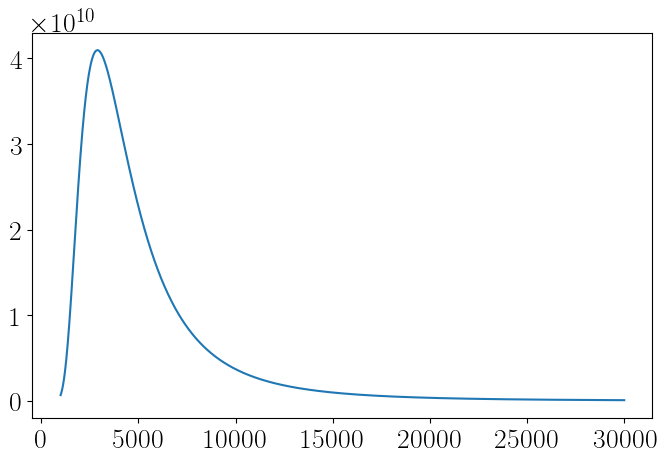

In [35]:
plt.plot(wavelengths,bb_result1)
#plt.plot(wavelengths,bb_result2)

In [35]:
u.Angstrom

Unit("Angstrom")

In [36]:
bb10_tess = bb(m4_wave_tlim)
bb10_kep = bb(m4_wave_klim)

bb_tessfk = bb(tessfk_wave*u.AA) #use these
bb_kepfk = bb(kepfk_wave*u.AA)

print( 'BB_TESS / BB_Kep', np.sum(bb10_tess) / np.sum(bb10_kep))
print( 'BB_TESSfk / BB_Kepfk', np.sum(bb_tessfk) / np.sum(bb_kepfk))

BB_TESS / BB_Kep 1.073521151757298
BB_TESSfk / BB_Kepfk 0.15828550881810338


In [37]:
#kepfk_wave

In [38]:
bb_tessfk

<Quantity [0.00018633, 0.00018743, 0.00018822, 0.0001896 , 0.00018903,
           0.00018818, 0.00018665, 0.00018626, 0.00018601, 0.00018585,
           0.00018585, 0.00018567, 0.00018567, 0.00018558, 0.00018558,
           0.00018549, 0.00018549, 0.0001854 , 0.00018539, 0.00018538,
           0.0001853 , 0.00018529, 0.00018519, 0.00018509, 0.0001849 ,
           0.00018471, 0.00018471, 0.00018451, 0.0001845 , 0.00018439,
           0.0001842 , 0.00018409, 0.00018389, 0.00018359, 0.00018328,
           0.00018287, 0.00018266, 0.00018234, 0.00018202, 0.00018169,
           0.00018136, 0.00018091, 0.00018045, 0.00018011, 0.00017976,
           0.0001794 , 0.00017904, 0.00017856, 0.00017807, 0.00017745,
           0.0001767 , 0.00017606, 0.00017542, 0.00017477, 0.00017424,
           0.00017358, 0.00017278, 0.00017197, 0.00017142, 0.0001706 ,
           0.0001695 , 0.00016838, 0.00016754, 0.0001667 , 0.00016613,
           0.00016556, 0.00016514, 0.00016471, 0.00016414, 0.00016357,
      

In [39]:
tessfk_wave*u.Angstrom

<Quantity [ 4540.50073638,  4637.70250368,  4726.06774669,  5070.6921944 ,
            5362.29749632,  5521.35493373,  5724.59499264,  5768.84258858,
            5795.41713593,  5813.22013341,  5813.3500823 ,  5831.25054145,
            5831.44546478,  5840.54188686,  5840.83427185,  5849.99566837,
            5850.35302781,  5859.64437321,  5860.16416876,  5861.17127263,
            5869.39053972,  5870.49510526,  5880.07883566,  5889.88997661,
            5908.11530798,  5926.43810101,  5926.95789656,  5945.41063848,
            5946.51520402,  5956.26137053,  5974.68162523,  5984.33033007,
            6002.81555921,  6029.55254267,  6056.09460279,  6091.47318721,
            6109.21121026,  6135.72078316,  6162.26284328,  6188.77241618,
            6215.34696353,  6250.72554795,  6286.07164515,  6312.6461925 ,
            6339.1557654 ,  6365.6653383 ,  6392.23988564,  6427.58598285,
            6462.96456727,  6507.17967599,  6560.23130902,  6604.47890496,
            6648.66152647

In [40]:
#plt.plot(bb10_kep,m4_flux_klim)
#plt.plot(bb10_tess,m4_flux_tlim)

In [41]:
#kep_tm_norm * bb10_kep # bb flux in each curve

BB Flux in each filter curve: similar to Howard 2021 figure 3 which was based on fig 12 in Schmitt 2019 (https://www.aanda.org/articles/aa/pdf/2019/08/aa35374-19.pdf)

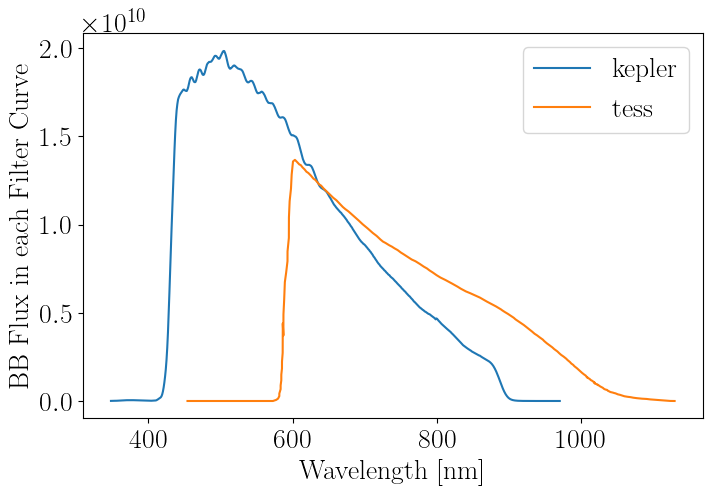

In [37]:
plt.plot(kepfk_wave/10,bb_kepfk*kep_tm_norm, label ='kepler') # bb flux in each curve
plt.plot(tessfk_wave/10,bb_tessfk*tess_tm_norm, label ='tess')

plt.xlabel('Wavelength [nm]')
plt.ylabel('BB Flux in each Filter Curve')
plt.legend()

In [43]:
#plt.plot(kepfk_wave,kep_tm_norm, label ='kepler') # bb flux in each curve
#plt.plot(tessfk_wave,tess_tm_norm, label ='tess')

Text(0, 0.5, ' Flux[$10^{-13}$ erg $s^{-1} cm^{-2}A^{-1}$]')

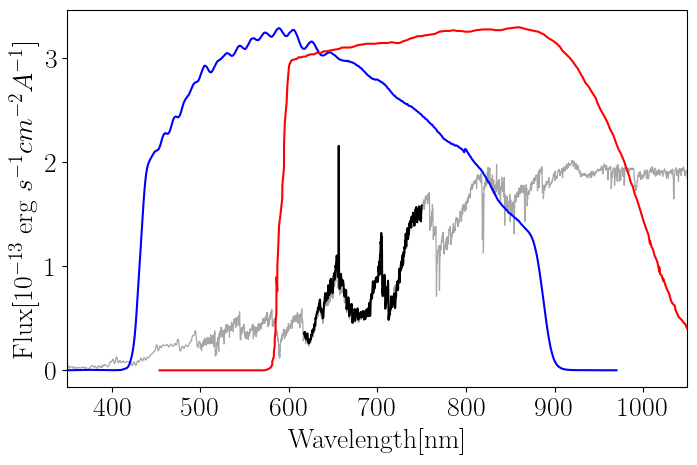

In [44]:
plt.plot(m4_wave/10,m4_flux*flux_convert/1e-13,color='grey',alpha=.7,linewidth=.9)
plt.plot(pmsu_wave[flux_mask]/10,pmsu_flux_cal[flux_mask]/1e-13,color='k')

plt.plot(kepfk_wave/10,kep_tm_norm*np.max(pmsu_flux_cal)/1e-13,color='blue',label='Kepler')
plt.plot(tessfk_wave/10,tessfk_tm*np.max(pmsu_flux_cal)/1e-13,color='red',label='TESS')

plt.xlim(350,1050)
plt.xlabel('Wavelength[nm]')
plt.ylabel(' Flux[$10^{-13}$ erg $s^{-1} cm^{-2}A^{-1}$]')

#plt.savefig('kep_vs_tess_bandpass.pdf',bbox_inches='tight')

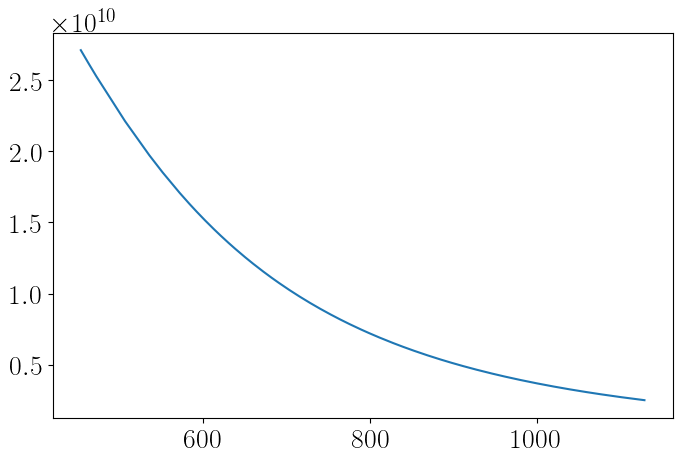

In [38]:
plt.plot(tessfk_wave/10,bb_tessfk)

Text(0, 0.5, ' Flux[$10^{-13}$ erg $s^{-1} cm^{-2}A^{-1}$]')

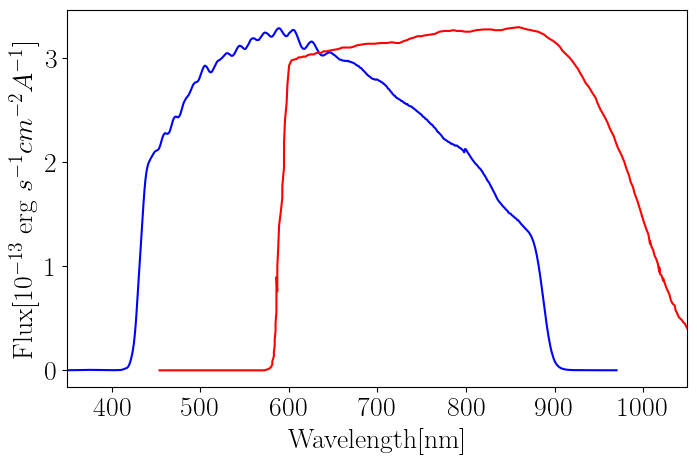

In [46]:
plt.plot(kepfk_wave/10,kep_tm_norm*np.max(pmsu_flux_cal)/1e-13,color='blue',label='Kepler')
plt.plot(tessfk_wave/10,tessfk_tm*np.max(pmsu_flux_cal)/1e-13,color='red',label='TESS')

plt.xlim(350,1050)
plt.xlabel('Wavelength[nm]')
plt.ylabel(' Flux[$10^{-13}$ erg $s^{-1} cm^{-2}A^{-1}$]')

Drawing a flare using the 2021 flare model

In [47]:
import sys  
sys.path.append('/Users/lupitatovar/Llamaradas-Estelares/') #Edit this to your own file path
from Flare_model import flare_model

In [242]:
#temp profile
time = np.arange(-20,100,.1)
flux = flare_model(time, 0, 5, 1) #flare model
temp10k = np.sqrt(flux)*10000 + 253
temp30k= np.sqrt(flux)*30000 + 758   #make sure it peaks at 30K

In [243]:
print(np.max(temp10k))
print(np.max(temp30k))

10000.429102340418
30000.28730702126


Text(0, 0.5, 'Relative Flux')

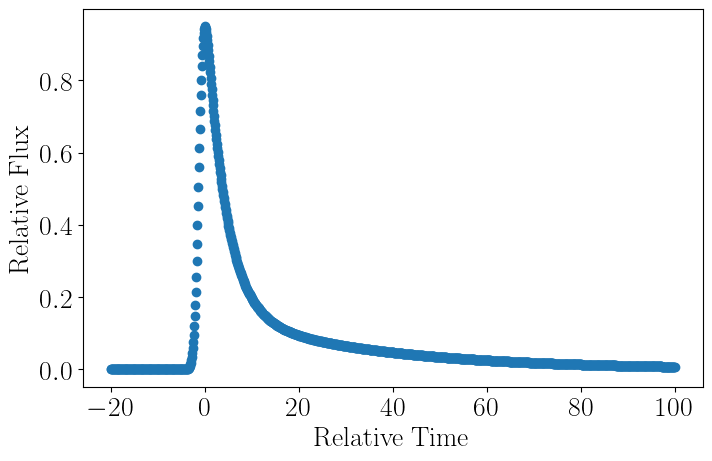

In [244]:
plt.scatter(time,flux)
#plt.plot(temp)
plt.xlabel('Relative Time')
plt.ylabel('Relative Flux')

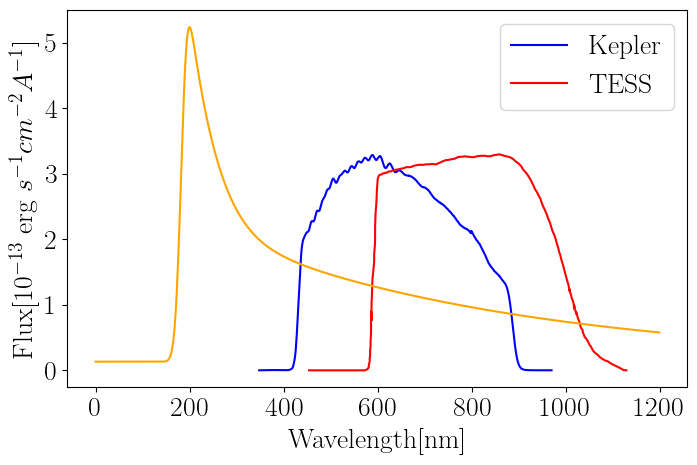

In [245]:
plt.plot(kepfk_wave/10,kep_tm_norm*np.max(pmsu_flux_cal)/1e-13,color='blue',label='Kepler')
plt.plot(tessfk_wave/10,tessfk_tm*np.max(pmsu_flux_cal)/1e-13,color='red',label='TESS')
#plt.plot(temp, color='orange')
plt.plot(temp10k/np.median(temp10k), color='orange')
#plt.plot(temp30k/np.median(temp30k), color='purple')
#plt.xlim(0,1400)
plt.xlabel('Wavelength[nm]')
plt.ylabel(' Flux[$10^{-13}$ erg $s^{-1} cm^{-2}A^{-1}$]')
plt.legend()

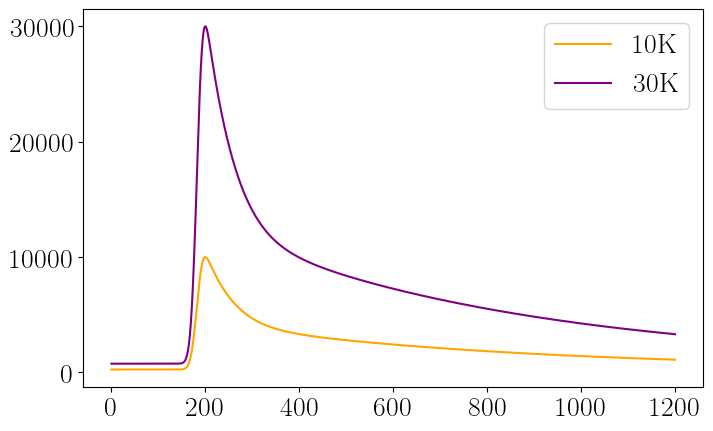

In [246]:
plt.plot(temp10k, color='orange',label='10K')
plt.plot(temp30k, color='purple',label='30K')
plt.legend()

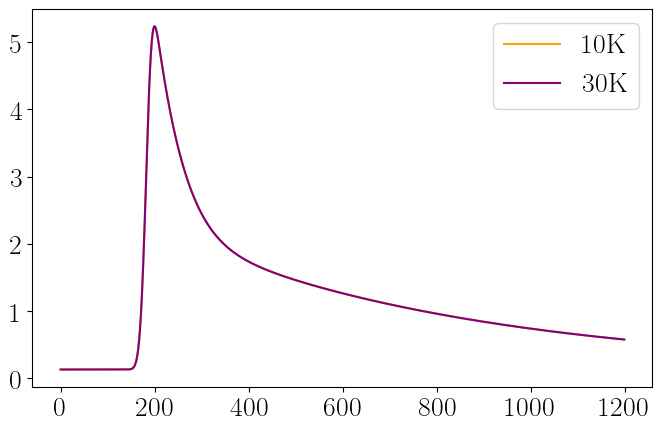

In [247]:
plt.plot(temp10k/np.median(temp10k), color='orange',label='10K')
plt.plot(temp30k/np.median(temp30k), color='purple',label='30K')
plt.legend()

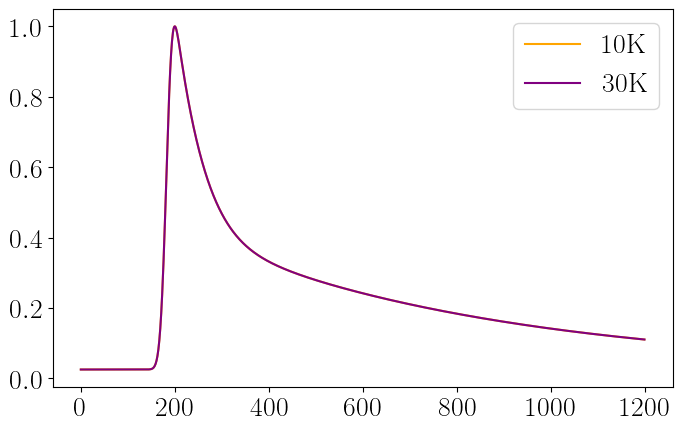

In [248]:
plt.plot(temp10k/np.max(temp10k), color='orange',label='10K')
plt.plot(temp30k/np.max(temp30k), color='purple',label='30K')
plt.legend()

In [173]:
#plt.plot((temp) ,bb_kepfk*kep_tm_norm)

In [174]:
bb_kepfk

<Quantity [0.0001534 , 0.00015393, 0.00015445, 0.00015497, 0.00015548,
           0.00015599, 0.00015649, 0.00015699, 0.00015749, 0.00015798,
           0.00015847, 0.00015895, 0.00015942, 0.0001599 , 0.00016036,
           0.00016083, 0.00016129, 0.00016174, 0.00016219, 0.00016263,
           0.00016308, 0.00016351, 0.00016394, 0.00016437, 0.00016479,
           0.00016521, 0.00016563, 0.00016604, 0.00016644, 0.00016684,
           0.00016724, 0.00016763, 0.00016802, 0.00016841, 0.00016879,
           0.00016916, 0.00016954, 0.0001699 , 0.00017027, 0.00017063,
           0.00017098, 0.00017133, 0.00017168, 0.00017202, 0.00017236,
           0.0001727 , 0.00017303, 0.00017335, 0.00017368, 0.000174  ,
           0.00017431, 0.00017462, 0.00017493, 0.00017523, 0.00017553,
           0.00017583, 0.00017612, 0.00017641, 0.00017669, 0.00017697,
           0.00017725, 0.00017752, 0.00017779, 0.00017806, 0.00017832,
           0.00017858, 0.00017884, 0.00017909, 0.00017934, 0.00017958,
      

In [175]:
bb_kepfk

<Quantity [0.0001534 , 0.00015393, 0.00015445, 0.00015497, 0.00015548,
           0.00015599, 0.00015649, 0.00015699, 0.00015749, 0.00015798,
           0.00015847, 0.00015895, 0.00015942, 0.0001599 , 0.00016036,
           0.00016083, 0.00016129, 0.00016174, 0.00016219, 0.00016263,
           0.00016308, 0.00016351, 0.00016394, 0.00016437, 0.00016479,
           0.00016521, 0.00016563, 0.00016604, 0.00016644, 0.00016684,
           0.00016724, 0.00016763, 0.00016802, 0.00016841, 0.00016879,
           0.00016916, 0.00016954, 0.0001699 , 0.00017027, 0.00017063,
           0.00017098, 0.00017133, 0.00017168, 0.00017202, 0.00017236,
           0.0001727 , 0.00017303, 0.00017335, 0.00017368, 0.000174  ,
           0.00017431, 0.00017462, 0.00017493, 0.00017523, 0.00017553,
           0.00017583, 0.00017612, 0.00017641, 0.00017669, 0.00017697,
           0.00017725, 0.00017752, 0.00017779, 0.00017806, 0.00017832,
           0.00017858, 0.00017884, 0.00017909, 0.00017934, 0.00017958,
      

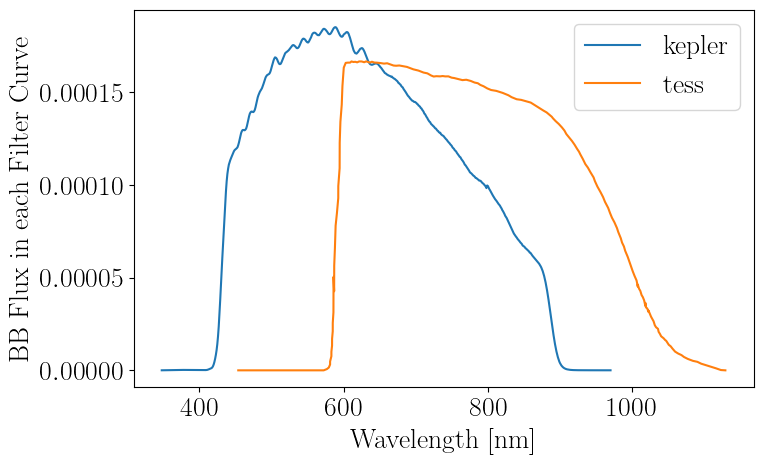

In [176]:
##
plt.plot(kepfk_wave/10,bb_kepfk*kep_tm_norm, label ='kepler') # bb flux in each curve
plt.plot(tessfk_wave/10,bb_tessfk*tess_tm_norm, label ='tess')

plt.xlabel('Wavelength [nm]')
plt.ylabel('BB Flux in each Filter Curve')
plt.legend()

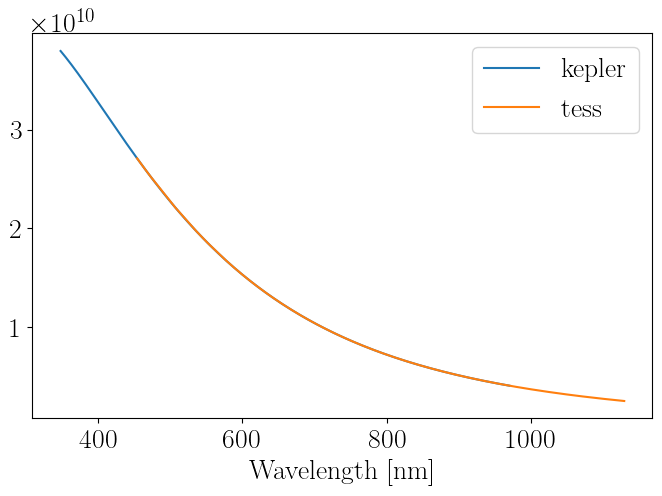

In [39]:
## lambda,
plt.plot(kepfk_wave/10,bb_kepfk, label ='kepler') # bb flux in each curve
plt.plot(tessfk_wave/10,bb_tessfk, label ='tess')

plt.xlabel('Wavelength [nm]')
#plt.ylabel('BB Flux in each Filter Curve')
plt.legend()

In [40]:
bb_kepfk*kep_tm_norm

<Quantity [5.87157790e+06, 7.88040834e+06, 8.25306793e+06, 1.00228782e+07,
           1.17528835e+07, 1.20921618e+07, 1.11797847e+07, 1.18477937e+07,
           1.43003540e+07, 1.68684569e+07, 1.94896639e+07, 2.16074807e+07,
           2.30729586e+07, 2.53470680e+07, 2.77807088e+07, 3.06399203e+07,
           3.41727946e+07, 3.71839321e+07, 3.94819992e+07, 4.15418962e+07,
           4.30267927e+07, 4.41796231e+07, 4.49485600e+07, 4.57465895e+07,
           4.61154548e+07, 4.60096326e+07, 4.60011246e+07, 4.88232059e+07,
           4.82638632e+07, 4.79249345e+07, 4.71269397e+07, 4.59222054e+07,
           4.45453498e+07, 4.33434029e+07, 4.17552992e+07, 4.00039627e+07,
           3.83144405e+07, 3.68284982e+07, 3.48922983e+07, 3.29811804e+07,
           3.10668785e+07, 2.88826945e+07, 2.72154016e+07, 2.58835133e+07,
           2.48654434e+07, 2.31411311e+07, 2.07772688e+07, 1.82992351e+07,
           1.69310649e+07, 1.73013672e+07, 1.82149285e+07, 1.88001554e+07,
           1.78711778e+07

In [179]:
u.angstrom

Unit("Angstrom")

In [180]:
(ac.c/((kepfk_wave*u.angstrom).to('m') )).to('Hz')
#ac.c

<Quantity [8.61472580e+14, 8.59004178e+14, 8.56549880e+14, 8.54109567e+14,
           8.51683119e+14, 8.49270419e+14, 8.46871350e+14, 8.44485797e+14,
           8.42113646e+14, 8.39754784e+14, 8.37409101e+14, 8.35076485e+14,
           8.32756828e+14, 8.30450022e+14, 8.28155961e+14, 8.25874540e+14,
           8.23605654e+14, 8.21349200e+14, 8.19105077e+14, 8.16873183e+14,
           8.14653418e+14, 8.12445686e+14, 8.10249886e+14, 8.08065925e+14,
           8.05893704e+14, 8.03733131e+14, 8.01584112e+14, 7.99446555e+14,
           7.97320367e+14, 7.95205459e+14, 7.93101741e+14, 7.91009124e+14,
           7.88927521e+14, 7.86856845e+14, 7.84797010e+14, 7.82747932e+14,
           7.80709526e+14, 7.78681709e+14, 7.76664399e+14, 7.74657514e+14,
           7.72660974e+14, 7.70674699e+14, 7.68698610e+14, 7.66732629e+14,
           7.64776679e+14, 7.62830682e+14, 7.60894563e+14, 7.58968248e+14,
           7.57051662e+14, 7.55144730e+14, 7.53247382e+14, 7.51359544e+14,
           7.49481145e+14

In [181]:
ang_units

Unit("erg / (Angstrom cm2 s sr)")

Calculating the Flux Ratio between the two bandpasses

In [41]:
kep_trapz = np.trapz(bb_kepfk*kep_tm_norm,x=(((kepfk_wave*u.angstrom) )))
tess_trapz = np.trapz(bb_tessfk*tess_tm_norm,x=(((tessfk_wave*u.angstrom))))

In [42]:
print(kep_trapz)
print(tess_trapz)

51272454114463.484 erg / (cm2 s sr)
31464685666805.703 erg / (cm2 s sr)


In [43]:
print(kep_trapz)
print(tess_trapz)

51272454114463.484 erg / (cm2 s sr)
31464685666805.703 erg / (cm2 s sr)


In [44]:
print(kep_trapz)
print(tess_trapz)

51272454114463.484 erg / (cm2 s sr)
31464685666805.703 erg / (cm2 s sr)


In [45]:
print('Flux Ratio:',kep_trapz/tess_trapz)
print('log Flux Ratio:',np.log10(kep_trapz/tess_trapz))

Flux Ratio: 1.6295237987568514
log Flux Ratio: 0.2120607076015935


In [46]:
print('Flux Ratio:',kep_trapz/tess_trapz)
print('log Flux Ratio:',np.log10(kep_trapz/tess_trapz))

Flux Ratio: 1.6295237987568514
log Flux Ratio: 0.2120607076015935


In [47]:
print('Flux Ratio:',kep_trapz/tess_trapz)
#print('Flux Ratio:',tess_trapz/kep_trapz)

Flux Ratio: 1.6295237987568514


In [189]:
print('log Flux Ratio:',np.log10(kep_trapz/tess_trapz)) #this gives color-like val

log Flux Ratio: 0.011336877704532924


In [190]:
temps = np.arange(5000,26000,1000)
temps

array([ 5000,  6000,  7000,  8000,  9000, 10000, 11000, 12000, 13000,
       14000, 15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000,
       23000, 24000, 25000])

In [191]:
temps.shape[0]

21

### Trying out the Isochrone Comparison

In [192]:
iso_temp = pd.read_csv('MIST_iso.cmd',skiprows= 12,delim_whitespace='True')

In [193]:
iso_temp2 = pd.read_csv('MIST_iso8.cmd',skiprows= 12,delim_whitespace='True')

In [194]:
iso = pd.read_csv('MIST_iso.cmd',skiprows= 13,names= iso_temp.columns.values[1:],delim_whitespace='True')

In [195]:
iso8 = pd.read_csv('MIST_iso8.cmd',skiprows= 13,names= iso_temp2.columns.values[1:],delim_whitespace='True')

In [196]:
iso8

,EEP,log10_isochrone_age_yr,initial_mass,star_mass,log_Teff,log_g,log_L,[Fe/H]_init,[Fe/H],Bessell_U,...,Gaia_RP_DR2Rev,Gaia_G_MAW,Gaia_BP_MAWb,Gaia_BP_MAWf,Gaia_RP_MAW,TESS,Gaia_G_EDR3,Gaia_BP_EDR3,Gaia_RP_EDR3,phase
0,148,8.0,0.100000,0.100000,3.475911,4.875673,-2.579239,0.0,0.041367,16.730181,...,11.298163,12.548005,14.460276,14.501665,11.273355,11.158971,12.566910,14.483248,11.270813,-1.0
1,149,8.0,0.101980,0.101979,3.476309,4.875401,-2.570402,0.0,0.041368,16.695061,...,11.272761,12.521215,14.426934,14.468332,11.247983,11.134188,12.540132,14.449886,11.245422,-1.0
2,150,8.0,0.105967,0.105967,3.477019,4.874702,-2.552821,0.0,0.041366,16.627922,...,11.222961,12.468931,14.363027,14.404439,11.198236,11.085487,12.487869,14.385941,11.195642,-1.0
3,151,8.0,0.110036,0.110036,3.478102,4.873986,-2.533441,0.0,0.041366,16.544853,...,11.165702,12.407861,14.284382,14.325821,11.141057,11.029898,12.426831,14.307238,11.138416,-1.0
4,152,8.0,0.114150,0.114150,3.479405,4.873312,-2.513064,0.0,0.041366,16.453014,...,11.104310,12.341830,14.197350,14.238824,11.079762,10.970504,12.360838,14.220131,11.077074,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558,1706,8.0,5.412558,0.929765,4.690098,8.439059,-0.317506,0.0,0.108334,8.465498,...,10.286777,9.942456,9.766394,9.708340,10.271724,10.275082,9.948283,9.772223,10.291054,5.0
1559,1707,8.0,5.414637,0.929922,4.682331,8.440658,-0.350097,0.0,0.108347,8.493608,...,10.310579,9.967136,9.791694,9.733903,10.295517,10.298794,9.973035,9.797555,10.314837,5.0
1560,1708,8.0,5.416887,0.930091,4.674587,8.442257,-0.382598,0.0,0.108358,8.513177,...,10.326496,9.984388,9.809492,9.751837,10.311422,10.314774,9.990320,9.815372,10.330748,5.0
1561,1709,8.0,5.419317,0.930274,4.666865,8.443864,-0.415007,0.0,0.108371,8.529256,...,10.339125,9.998570,9.824198,9.766626,10.324039,10.327530,10.004519,9.830094,10.343372,5.0


In [197]:
print(iso['Kepler_Kp'].values)
print(iso['TESS'].values)


[13.903664 13.794009 13.646496 ... 10.191353 10.234149 10.279195]
[12.317294 12.224094 12.098401 ... 10.389101 10.42898  10.470944]


In [198]:
iso['Gaia_G_EDR3'].values

array([13.808018, 13.702909, 13.561411, ..., 10.148885, 10.193575,
       10.240599])

In [199]:
iso['Gaia_G_MAW'].values

array([13.789265, 13.684076, 13.542477, ..., 10.138878, 10.183365,
       10.230175])

In [200]:
kep_min_tess = iso['Kepler_Kp'].values - iso['TESS'].values

In [201]:
kep_min_tess8 = iso8['Kepler_Kp'].values - iso8['TESS'].values

### CMD

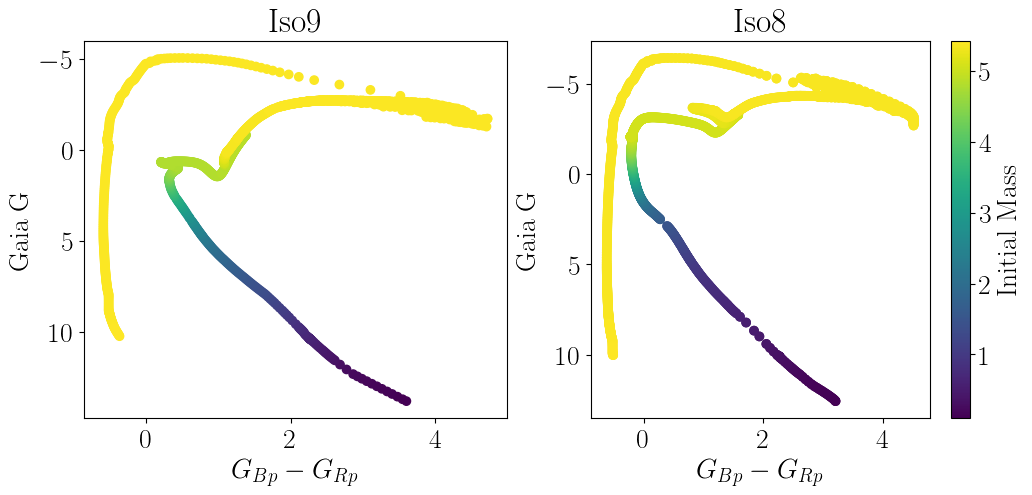

In [202]:
fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(iso['Gaia_BP_EDR3'].values - iso['Gaia_RP_EDR3'],iso['Gaia_G_EDR3'].values, c=iso['initial_mass'].values)
axs[0].set_xlabel('$G_{Bp}-G_{Rp}$')
axs[0].set_ylabel('Gaia G')
axs[0].set_title("Iso9")
axs[0].invert_yaxis()
               
axs[1].scatter(iso8['Gaia_BP_EDR3'].values - iso8['Gaia_RP_EDR3'],iso8['Gaia_G_EDR3'].values, c=iso8['initial_mass'].values)
axs[1].set_xlabel('$G_{Bp}-G_{Rp}$')
axs[1].set_ylabel('Gaia G')
axs[1].set_title("Iso8")
axs[1].invert_yaxis()



#fig.subplots_adjust(right=0.85)
#cbar_ax = fig.add_axes([0.91, 0.13, 0.02, 0.74])
#s4 = plt.scatter(energy[dur_mask],tess_flare_vals['amps'].values[dur_mask],marker='o',c=durations_min)
#fig.colorbar(s4, cax=cbar_ax,label='Flare Duration [min]')

scatter8 = plt.scatter(iso8['Gaia_BP_EDR3'].values - iso8['Gaia_RP_EDR3'],iso8['Gaia_G_EDR3'].values, c=iso8['initial_mass'].values)
fig.colorbar(scatter8,label='Initial Mass')
#axs[0].colorbar(scatter, label='Initial Mass')



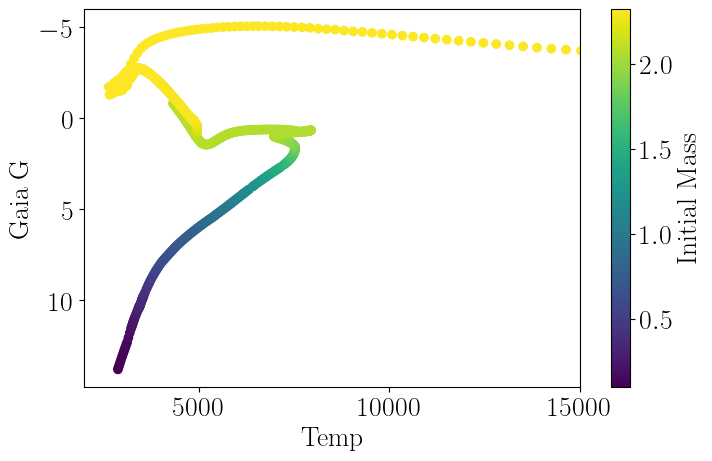

In [203]:
scatter3 = plt.scatter(10**iso['log_Teff'].values,iso['Gaia_G_EDR3'].values, c=iso['initial_mass'].values)
plt.colorbar(scatter3, label='Initial Mass')
plt.xlabel('Temp')
plt.ylabel('Gaia G')
plt.xlim(2000,15000)
plt.gca().invert_yaxis()

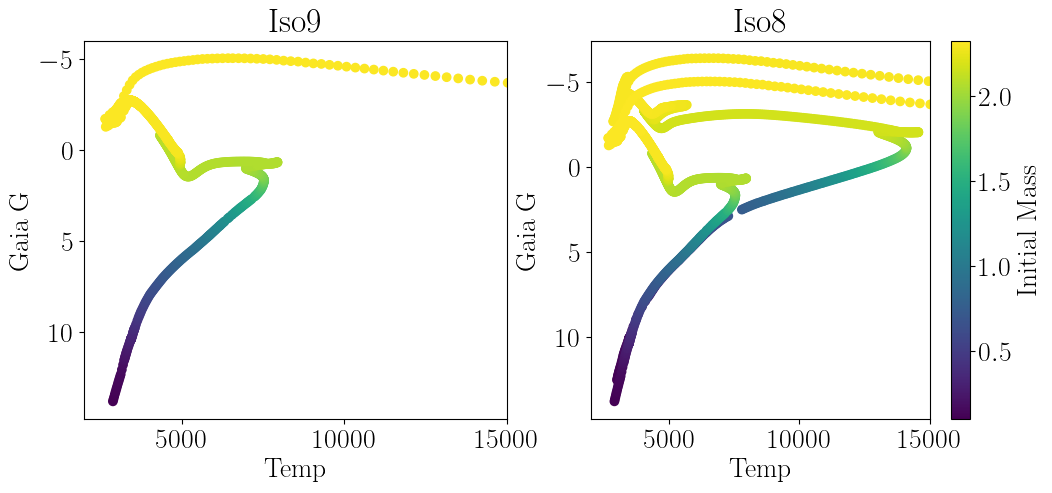

In [204]:
fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')


axs[0].scatter(10**iso['log_Teff'].values,iso['Gaia_G_EDR3'].values, c=iso['initial_mass'].values)
axs[0].set_xlabel('Temp')
axs[0].set_ylabel('Gaia G')
axs[0].set_title("Iso9")
axs[0].invert_yaxis()
axs[0].set_xlim(2000,15000)
               
axs[1].scatter(10**iso8['log_Teff'].values,iso8['Gaia_G_EDR3'].values, c=iso8['initial_mass'].values)
axs[1].set_xlabel('Temp')
axs[1].set_ylabel('Gaia G')
axs[1].set_title("Iso8")
axs[1].invert_yaxis()
axs[1].set_xlim(2000,15000)



scatter3 = plt.scatter(10**iso['log_Teff'].values,iso['Gaia_G_EDR3'].values, c=iso['initial_mass'].values)
plt.colorbar(scatter3, label='Initial Mass')

### Gaia G on y axis and (kep-tess) on x axis

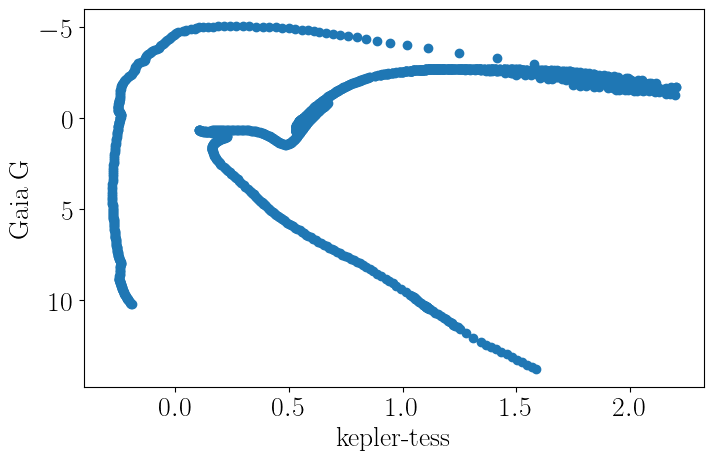

In [205]:
plt.scatter(kep_min_tess,iso['Gaia_G_EDR3'].values)
plt.xlabel('kepler-tess')
plt.ylabel('Gaia G')
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Iso9')

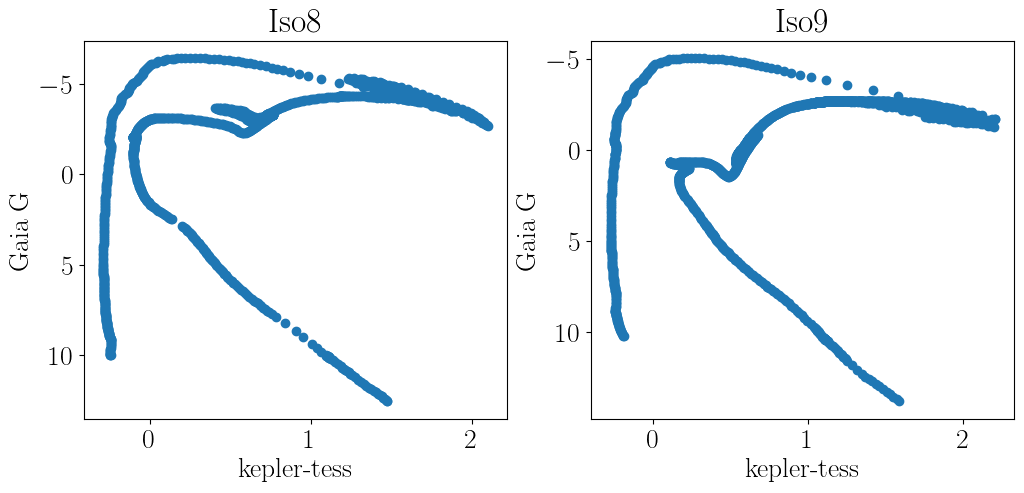

In [206]:
fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')

axs[0].scatter(kep_min_tess8,iso8['Gaia_G_EDR3'].values)
axs[0].set_xlabel('kepler-tess')
axs[0].set_ylabel('Gaia G')
axs[0].invert_yaxis()
axs[0].set_title("Iso8")

axs[1].scatter(kep_min_tess,iso['Gaia_G_EDR3'].values)
axs[1].set_xlabel('kepler-tess')
axs[1].set_ylabel('Gaia G')
axs[1].invert_yaxis()
axs[1].set_title("Iso9")

### temperature (x) versus kep-tess (y) in range of 10K-15K of temp

Text(0.5, 1.0, 'Iso9')

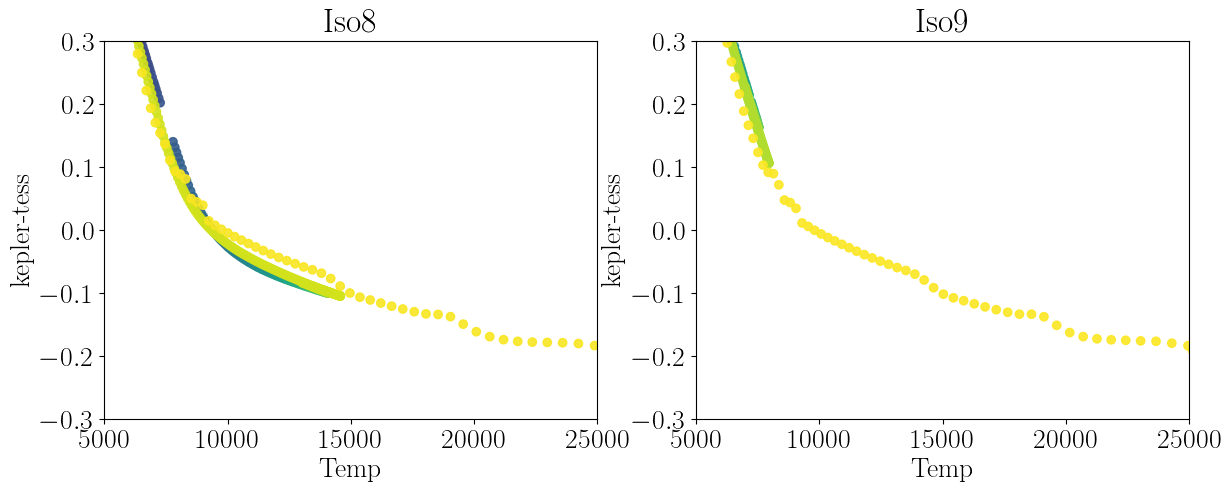

In [207]:
fig, axs = plt.subplots(1,2, figsize=(14,5), facecolor='w', edgecolor='k')

axs[0].scatter(10**iso8['log_Teff'].values,kep_min_tess8, c=iso8['initial_mass'].values,alpha=0.9)
axs[0].set_ylabel('kepler-tess')
axs[0].set_xlabel('Temp')
axs[0].set_xlim(5000,25000)
axs[0].set_ylim(-0.3,0.3)
axs[0].set_title("Iso8")

axs[1].scatter(10**iso['log_Teff'].values,kep_min_tess, c=iso['initial_mass'].values,alpha=0.9)
axs[1].set_ylabel('kepler-tess')
axs[1].set_xlabel('Temp')
axs[1].set_xlim(5000,25000)
axs[1].set_ylim(-0.3,0.3)
axs[1].set_title("Iso9")

#scatter2 = plt.scatter(10**iso8['log_Teff'].values,kep_min_tess8, c=iso8['initial_mass'].values,alpha=0.9)
#plt.colorbar(scatter2, label='Initial Mass 8')

(-0.3, 0.3)

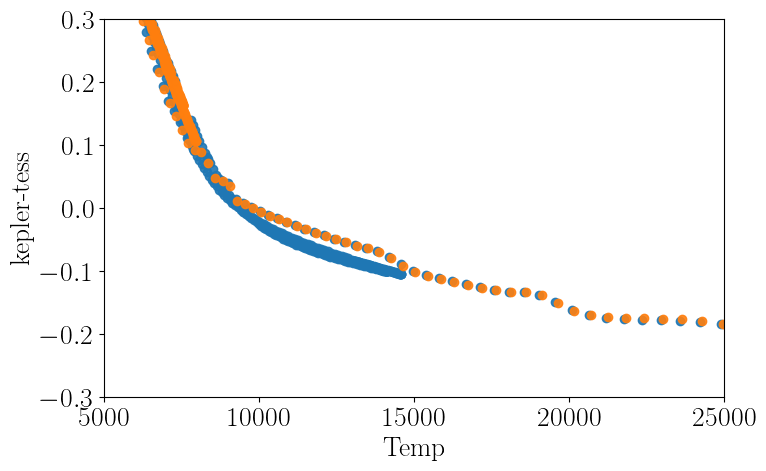

In [208]:
#fig, axs = plt.subplots(1,1, figsize=(14,5), facecolor='w', edgecolor='k')

plt.scatter(10**iso8['log_Teff'].values,kep_min_tess8, alpha=0.9)
plt.scatter(10**iso['log_Teff'].values,kep_min_tess,alpha=0.9)
plt.ylabel('kepler-tess')
plt.xlabel('Temp')
plt.xlim(5000,25000)
plt.ylim(-0.3,0.3)
#axs[0].set_title("Iso8")


Text(0, 0.5, 'Kepler-Tess')

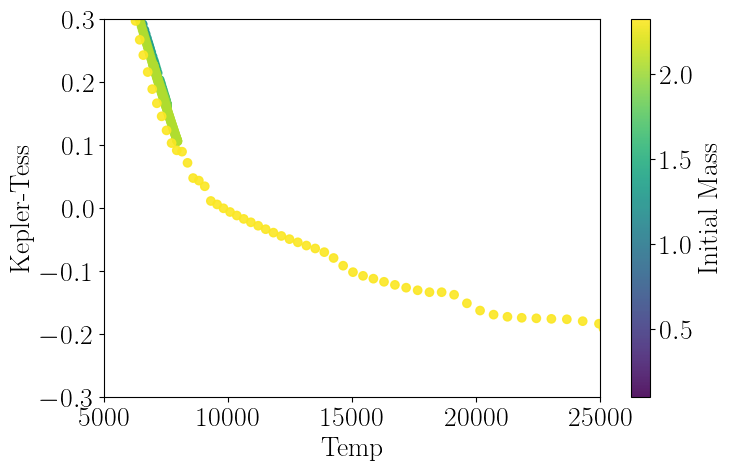

In [209]:
scatter2 = plt.scatter(10**iso['log_Teff'].values,kep_min_tess, c=iso['initial_mass'].values,alpha=0.9)
plt.colorbar(scatter2, label='Initial Mass')
plt.xlim(5000,25000)
plt.ylim(-0.3,0.3)
#plt.xscale('log')
plt.xlabel( 'Temp')
plt.ylabel('Kepler-Tess')

In [210]:
tess_div_kep = 10** (kep_min_tess*0.4)
tess_div_kep8 = 10** (kep_min_tess8*0.4)

Text(0, 0.5, 'tess/kep')

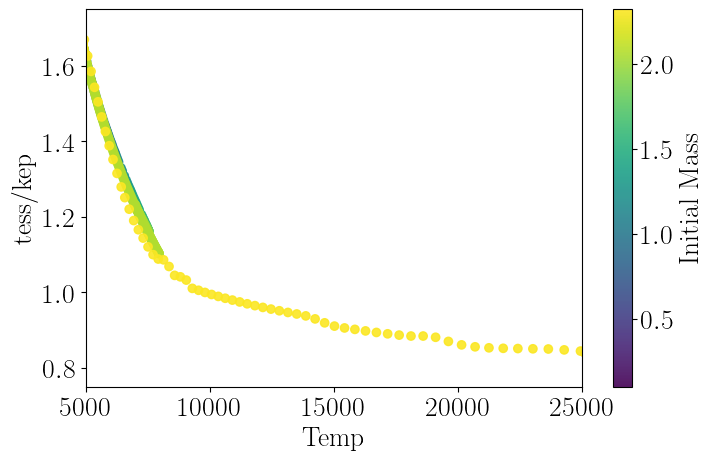

In [211]:
scatter4 = plt.scatter(10**iso['log_Teff'].values,tess_div_kep, c=iso['initial_mass'].values,alpha=0.9)
plt.colorbar(scatter4, label='Initial Mass')
plt.xlim(5000,25000)
plt.ylim(0.75,1.75)
#plt.xscale('log')
plt.xlabel( 'Temp')
plt.ylabel('tess/kep')

Text(0, 0.5, 'tess/kep')

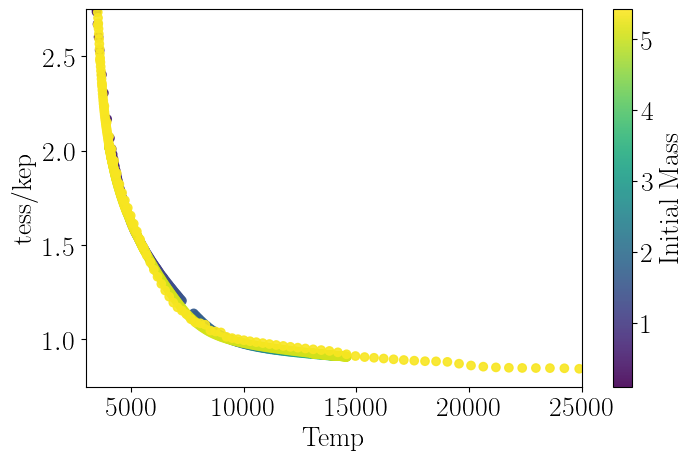

In [212]:
scatter48 = plt.scatter(10**iso8['log_Teff'].values,tess_div_kep8, c=iso8['initial_mass'].values,alpha=0.9)
plt.colorbar(scatter48, label='Initial Mass')
plt.xlim(3000,25000)
plt.ylim(0.75,2.75)
#plt.xscale('log')
plt.xlabel( 'Temp')
plt.ylabel('tess/kep')

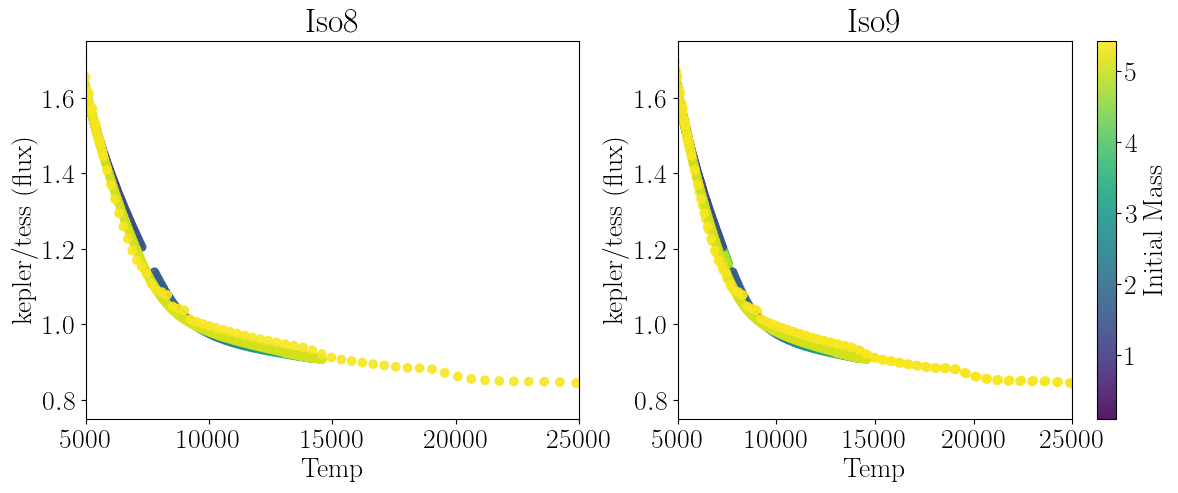

In [213]:
fig, axs = plt.subplots(1,2, figsize=(14,5), facecolor='w', edgecolor='k')

axs[0].scatter(10**iso8['log_Teff'].values,tess_div_kep8, c=iso8['initial_mass'].values,alpha=0.9)
axs[0].set_ylabel('kepler/tess (flux)')
axs[0].set_xlabel('Temp')
axs[0].set_xlim(5000,25000)
axs[0].set_ylim(0.75,1.75)
axs[0].set_title("Iso8")

axs[1].scatter(10**iso['log_Teff'].values,tess_div_kep, c=iso['initial_mass'].values,alpha=0.9)
axs[1].set_ylabel('kepler/tess (flux)')
axs[1].set_xlabel('Temp')
axs[1].set_xlim(5000,25000)
axs[1].set_ylim(.75,1.75)
axs[1].set_title("Iso9")

#scatter4 = plt.scatter(10**iso['log_Teff'].values,tess_div_kep, c=iso['initial_mass'].values,alpha=0.9)
#plt.colorbar(scatter4, label='Initial Mass')

scatter48 = plt.scatter(10**iso8['log_Teff'].values,tess_div_kep8, c=iso8['initial_mass'].values,alpha=0.9)
plt.colorbar(scatter48, label='Initial Mass')

In [214]:
10**iso['log_Teff'].values

array([ 2885.68082099,  2901.6798703 ,  2923.41154052, ...,
       26108.77697574, 25630.31372051, 25128.14949425])

Fitting 3rd order polynomial

Text(0, 0.5, 'kepler-tess')

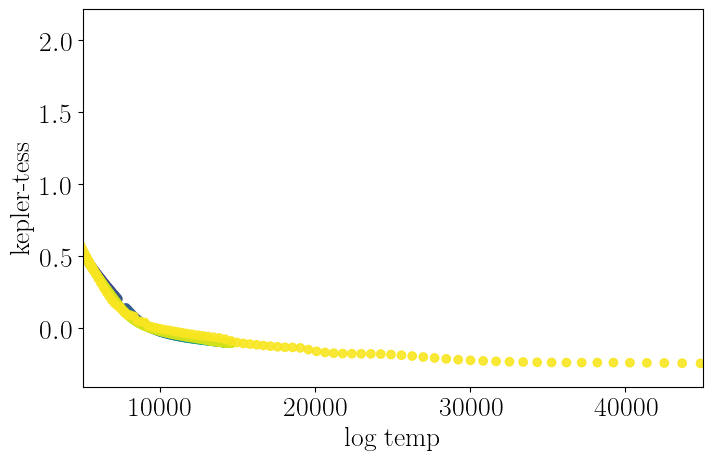

In [304]:
plt.scatter(10**iso8['log_Teff'].values,kep_min_tess8, c=iso8['initial_mass'].values,alpha=0.9)
plt.xlim(5000,45000)
plt.xlabel('log temp')
plt.ylabel('kepler-tess')

In [313]:
temperature = iso8['log_Teff'].values
xmin = np.log10(5000)
xmax = np.log10(45000)
temp_mask = np.where((temperature > xmin) & (temperature < xmax))[0]
x_fit = temperature[temp_mask]
y_fit = kep_min_tess8[temp_mask] #do flux ratio kep dv tess instead of mag
z = np.polyfit(x_fit,y_fit,7)

In [314]:
#flux ratio 
x_fit = temperature[temp_mask]
y_fit_fr = tess_div_kep8[temp_mask] #do flux ratio kep dv tess instead of mag
z_fr = np.polyfit(x_fit,y_fit_fr,7)
p_fr = np.poly1d(z_fr)

In [315]:
p_fr = np.poly1d(z_fr)
print(p_fr)

       7        6             5             4             3
37.19 x - 1117 x + 1.435e+04 x - 1.023e+05 x + 4.371e+05 x
              2
 - 1.119e+06 x + 1.589e+06 x - 9.651e+05


In [316]:
z

array([ 1.41821764e+01, -4.46087146e+02,  5.98681585e+03, -4.44516272e+04,
        1.97247555e+05, -5.23172106e+05,  7.68113707e+05, -4.81615370e+05])

In [317]:
p = np.poly1d(z)
print(p)

       7         6        5             4             3             2
14.18 x - 446.1 x + 5987 x - 4.445e+04 x + 1.972e+05 x - 5.232e+05 x + 7.681e+05 x - 4.816e+05


Text(0, 0.5, 'kepler-tess')

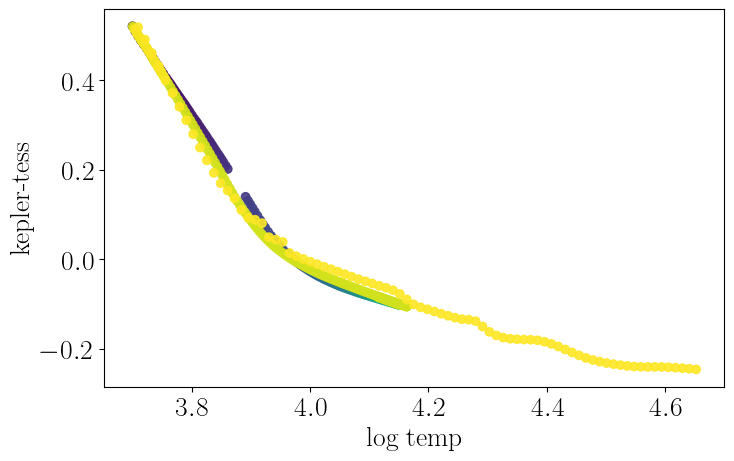

In [318]:
plt.scatter(x_fit,y_fit, c=iso8['initial_mass'].values[temp_mask],alpha=0.9)
#plt.plot(z,color='orange',lw=5)
#plt.plot(p,color='green',lw=5)
#plt.xlim(5000,25000)
#plt.ylim(-0.3,0.6)
plt.xlabel('log temp')
plt.ylabel('kepler-tess')


Text(0, 0.5, 'kepler-tess mag diff')

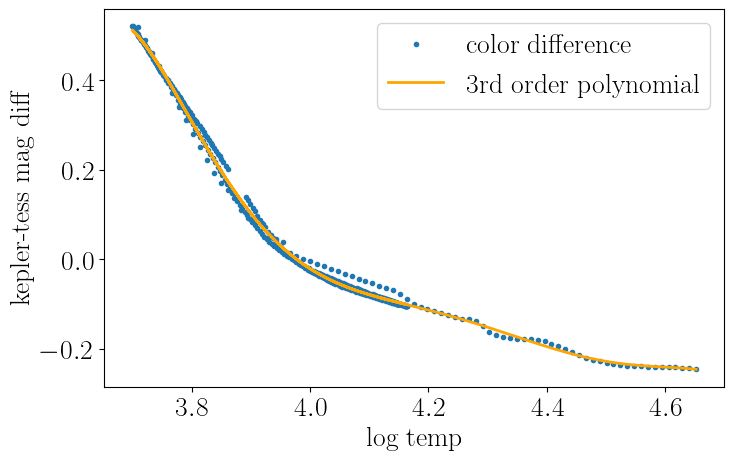

In [319]:
#xp = np.linspace(5000, 25000, 100)
plt.plot(x_fit, y_fit, '.', color='C0',label=('color difference'))
plt.plot(x_fit, p(x_fit), '-',color='orange',lw=2,label='3rd order polynomial')
plt.legend()
plt.xlabel('log temp')
plt.ylabel('kepler-tess mag diff')

Text(0, 0.5, 'tess/kep flux ratio')

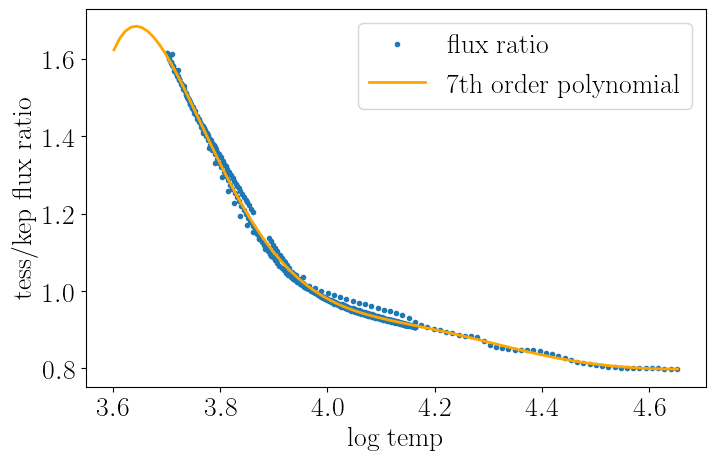

In [324]:
xp = np.log10(np.logspace(np.log10(4000), np.log10(45000), 100))
plt.plot(x_fit, y_fit_fr, '.', color='C0',label=('flux ratio '))
plt.plot(xp, p_fr(xp), '-',color='orange',lw=2,label='7th order polynomial')
plt.legend()
plt.xlabel('log temp')
plt.ylabel('tess/kep flux ratio')

Flipping x and y axes and then re-fitting so we can input a flux ration and get out a temperature

Text(0.5, 0, 'tess/kep flux ratio')

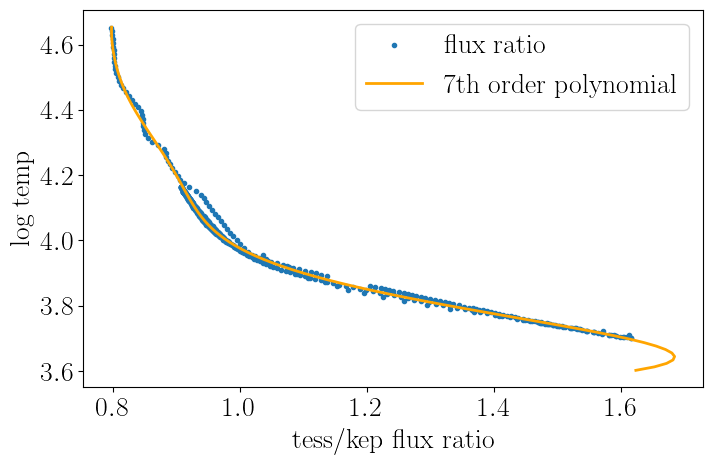

In [328]:
xp = np.log10(np.logspace(np.log10(4000), np.log10(45000), 100))
plt.plot( y_fit_fr,x_fit ,'.', color='C0',label=('flux ratio '))
plt.plot( p_fr(xp),xp, '-',color='orange',lw=2,label='7th order polynomial')
plt.legend()
plt.ylabel('log temp')
plt.xlabel('tess/kep flux ratio')

In [350]:
# refitting now that the axes are reversed

#flux ratio 
x_fit_temp = temperature[temp_mask]
y_fit_fr_temp = tess_div_kep8[temp_mask] #do flux ratio kep dv tess instead of mag
z_fr_temp = np.polyfit(y_fit_fr_temp,x_fit_temp,4)
p_fr_temp = np.poly1d(z_fr_temp)

Text(0.5, 0, 'tess/kep flux ratio')

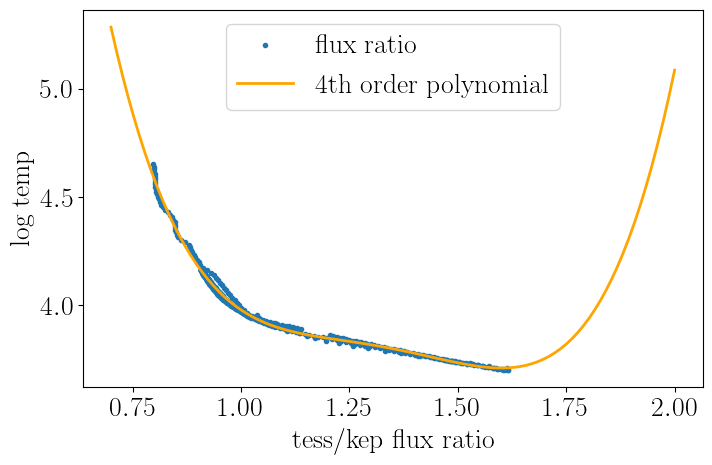

In [352]:
#xp = np.log10(np.logspace(np.log10(4000), np.log10(45000), 100))
xp= np.linspace(0.7,2,100)
plt.plot( y_fit_fr_temp,x_fit_temp ,'.', color='C0',label=('flux ratio '))
plt.plot( xp,p_fr_temp(xp), '-',color='orange',lw=2,label='4th order polynomial')
plt.legend()
plt.ylabel('log temp')
plt.xlabel('tess/kep flux ratio')

In [355]:
#assumming 10K bb what is p_fr aka flux ratio difference
#print(p_fr(1.3))
print(10** (p_fr_temp(.7)))

192451.01355487888


In [346]:
10**3.8

6309.57344480193

In [325]:
#(x_fit, p(x_fit))
#df = pd.DataFrame({"log temp" : x_fit, "flux ratio" : p_fr(x_fit)})
#df.to_csv("polyfit.csv", index=False)

Now drawing different temperature flares

Text(0, 0.5, 'log Temp')

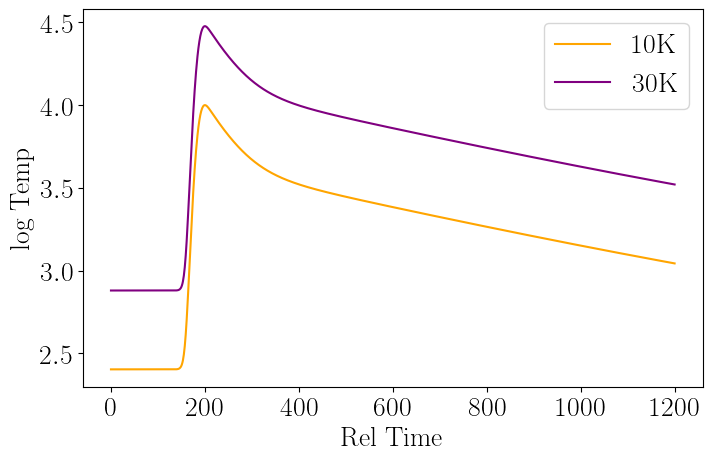

In [323]:
plt.plot(np.log10(temp10k), color='orange',label='10K')
plt.plot(np.log10(temp30k), color='purple',label='30K')
plt.legend()
plt.xlabel('Rel Time')
plt.ylabel('log Temp')

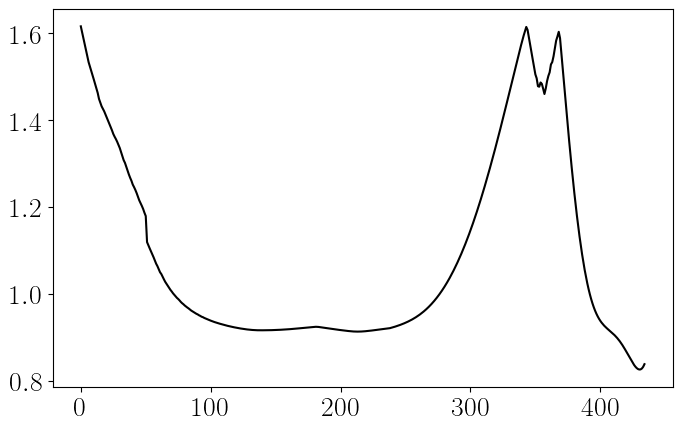

In [285]:
#plt.plot(np.log10(temp10k), color='orange',label='10K')
plt.plot(p_fr(x_fit),color='k')

In [302]:
#assumming 10K bb what is p_fr aka flux ratio difference
p_fr(4.6)

1.2086073724021844

In [294]:
print(p_fr(temp10k))

[2.81895754e+13 2.81895754e+13 2.81895754e+13 ... 4.83230906e+16
 4.80329996e+16 4.77447510e+16]


In [296]:
print(p_fr(3))

-26.537263219132


In [258]:
print(np.max(temp10k))
print(np.max(temp30k))

10000.429102340418
30000.28730702126


In [259]:
#interpolate temp10K to match p(x_fit)
print(len(p(x_fit)))
print(len(x_fit))

435
435


In [260]:
np.log10(temp10k)

array([2.40312052, 2.40312052, 2.40312052, ..., 3.04448882, 3.04396775,
       3.04344686])

In [261]:
x_vals10k = np.linspace(3.4,3.6,435)
print(len(x_vals10k))

435


In [262]:
pval10 = np.polyval(np.log10(temp10k),p(np.log10(temp10k)))

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:734: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]


In [263]:
len(pval10)

1200

In [264]:
##### mag diffs #####

interp10k = np.interp(np.log10(temp10k),x_fit,p(x_fit))
interp30k = np.interp(np.log10(temp30k),x_fit,p(x_fit))

In [265]:
###flux ratio #####

interp10k_fr = np.interp(np.log10(temp10k),x_fit,p_fr(x_fit))
interp30k_fr = np.interp(np.log10(temp30k),x_fit,p_fr(x_fit))

In [280]:
print(len(interp10k))
print(len(temp10k))
print(len(x_fit))
print(len(p_fr(x_fit)))

1200
1200
435
435


In [266]:
interp10k

array([0.51750056, 0.51750056, 0.51750056, ..., 0.51750056, 0.51750056,
       0.51750056])

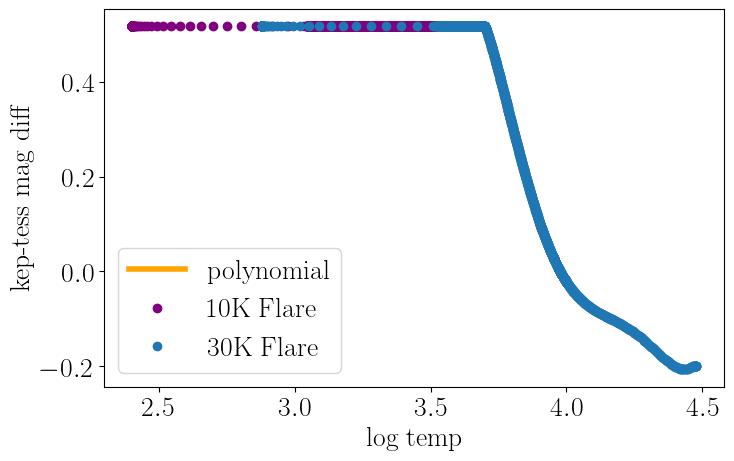

In [267]:
plt.plot(x_fit,p(x_fit),'-',color='orange',lw=4,label='polynomial')
plt.plot(np.log10(temp10k),interp10k,'o',color='purple',label='10K Flare')
plt.plot(np.log10(temp30k),interp30k,'o',color='C0',label='30K Flare')

#plt.plot(np.log10(temp10k),pval10)
plt.xlabel('log temp')
plt.ylabel('kep-tess mag diff')
plt.legend()

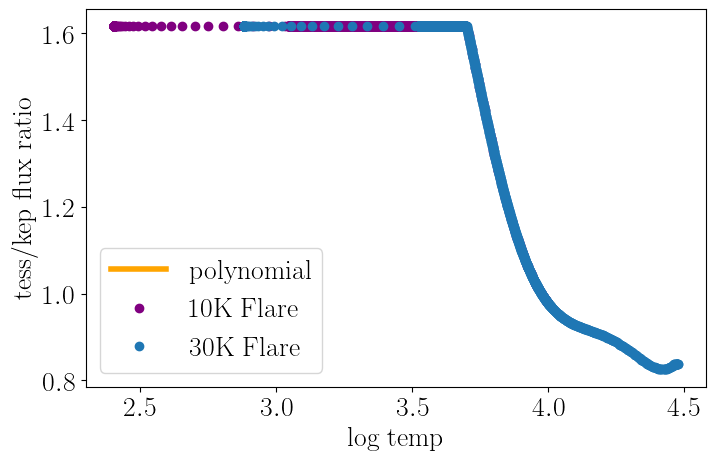

In [268]:
plt.plot(x_fit,p_fr(x_fit),'-',color='orange',lw=4,label='polynomial')
plt.plot(np.log10(temp10k),interp10k_fr,'o',color='purple',label='10K Flare')
plt.plot(np.log10(temp30k),interp30k_fr,'o',color='C0',label='30K Flare')

#plt.plot(np.log10(temp10k),pval10)
plt.xlabel('log temp')
plt.ylabel('tess/kep flux ratio')
plt.legend()

Comparing the magnitude differnce between kepler and tess as a function of time
Negative values correspond to "bluer" mags

Note the mag changes in the decay phase of flares at different bb temps

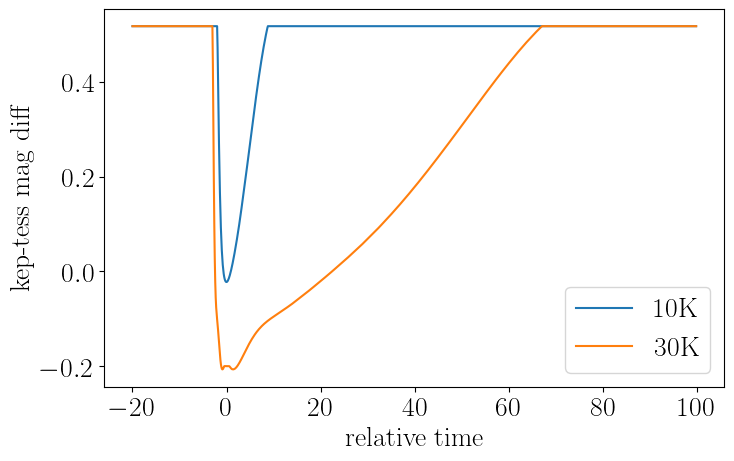

In [269]:
#plot(time v kep-tess)
plt.plot(time,interp10k,label='10K')

plt.plot(time,interp30k,label='30K')
plt.xlabel('relative time')
plt.ylabel('kep-tess mag diff')
plt.legend()

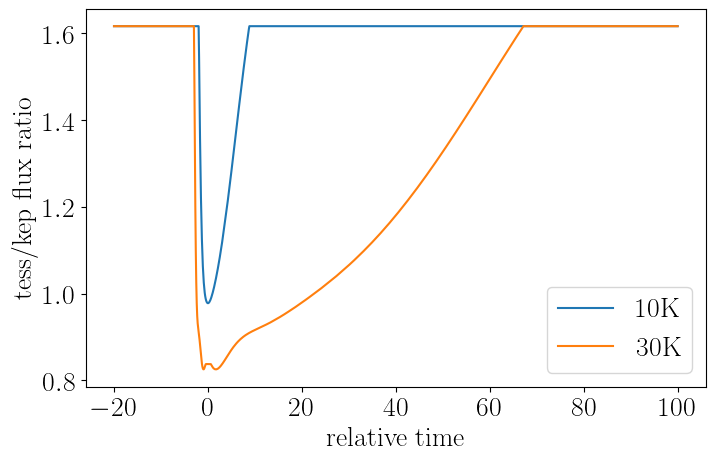

In [270]:
### FLux ratio

plt.plot(time,interp10k_fr,label='10K')

plt.plot(time,interp30k_fr,label='30K')
plt.xlabel('relative time')
plt.ylabel('tess/kep flux ratio')
plt.legend()

In [271]:
print(len(interp10k))
print(len(interp30k))

1200
1200


- mkep-mtess = difference in color (magnitude)
- convert abs mag to fluxes (m1-m2) =2.5*log10(I2/I1) where I2/I1 is a brightness ratio

In [159]:
#kep_min_tess = 2.5 * np.log10(I) solve for I

print(10** (kep_min_tess/-2.5))

[4.31070199 4.24586323 4.16138598 ... 0.83349078 0.83573309 0.8381088 ]


Star with temp of about 10,000K

In [136]:
temps10 = np.where(10**iso['log_Teff'].values >= 10000)
min(10**iso['log_Teff'].values[temps10])

10069.939974779716

Now calculating flux ratios for a wide range of bb temps

In [302]:
#temps = np.arange(5000,25000,1000)
for i in (temps):
    bb = BlackBody(temperature = temps[i])
    #kepbb = bb(kepk_wave)
    #tessbb= bb(tessfk_wave)
    #kepflux = np.trapz(kepbb[i]*kep_tm_norm ,x=(((kepfk_wave*u.angstrom).to('cm') )) )
    #tessflux = np.trapz(tessbb[i]*tess_tm_norm, x=(((tessfk_wave*u.angstrom).to('cm') )))

    #flux_ratio = kepflux(i)/tessflux(i)
    print (bb)

IndexError: index 5000 is out of bounds for axis 0 with size 21

What does that 10K flare look like in Kepler bandpass?

In [69]:
#plt.plot(temp10k,kep_trapz, color='C0',label='10K')
#plt.plot(temp30k, color='purple',label='30K')
#plt.legend()

In the TESS bandpass?

What is the difference in amplitude?